# Testing

In [1]:
%cd ..

/Users/udeepa/Documents/UCL/Term 2/COMP0082 Bioinformatics/project


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pickle

from Bio import SeqIO

from proteios.preprocess import preprocess, split_data
from proteios.featurise import Featuriser

In [3]:
np.random.seed(0)

### Get Data

In [ ]:
input_path = "input_data/"

In [4]:
classes = ["cytosolic", "secreted", "mitochondrial", "nuclear"]

# Get dictionaries for labels
label2index = {key:i for i, key in enumerate(classes)}
index2label = dict(zip(label2index.values(), label2index.keys())) 

# Get data
datasets = dict()
for label in classes:
    datasets[label] = list(SeqIO.parse(input_path+label+".fasta", "fasta"))
# Get test data
blind_test_x = list(SeqIO.parse(input_path+"blind_test.fasta", "fasta"))

# Get number of examples in each category
counts = {key:len(val) for i, (key,val) in enumerate(datasets.items())}
counts["total"] = sum([len(sublist) for keys, sublist in datasets.items()])
print(label2index)
print(counts)
print("Number of test data points:  ", len(blind_test_x))

{'cytosolic': 0, 'secreted': 1, 'mitochondrial': 2, 'nuclear': 3}
{'cytosolic': 3004, 'secreted': 1605, 'mitochondrial': 1299, 'nuclear': 3314, 'total': 9222}
Number of test data points:   20


In [5]:
# Preprocess the data
full_x, full_y = preprocess(datasets, 
                            label2index=label2index,
                            trim_outliers=True,
                            max_length=2000)
print()
blind_test_x = preprocess(blind_test_x, 
                          trim_outliers=True,
                          max_length=2000)
# Split the data
train_x, train_y, test_x, test_y = split_data(full_x, 
                                              full_y,
                                              train_size=0.9)
print()
print("Training data size: ", len(train_y))
print("Test data size:     ", len(test_y))
print("Distribution train: ", dict(collections.Counter(train_y)))
print("Distribution test:  ", dict(collections.Counter(test_y)))

Processing cytosolic
Data removed:  80
Processing secreted
Data removed:  19
Processing mitochondrial
Data removed:  2
Processing nuclear
Data removed:  66
Total Before:  9222
Total After:   9055

Processing tmp
Data removed:  0
Total Before:  20
Total After:   20

Training data size:  8148
Test data size:      907
Distribution train:  {1: 1427, 2: 1167, 3: 2923, 0: 2631}
Distribution test:   {3: 325, 0: 293, 1: 159, 2: 130}


### Get Features

In [6]:
# Get dictionaries
dicts = dict()
dicts['kd'] = pickle.load(open("input_data/scales/kd.pickle","rb"))
dicts['flex'] = pickle.load(open("input_data/scales/flex.pickle","rb"))
dicts['hw'] = pickle.load(open("input_data/scales/hw.pickle","rb"))
dicts['em'] = pickle.load(open("input_data/scales/em.pickle","rb"))
dicts['ja'] = pickle.load(open("input_data/scales/ja.pickle","rb"))
dicts['diwv'] = pickle.load(open("input_data/scales/diwv.pickle","rb"))  

In [7]:
featuriser = Featuriser(train_x, dicts)
full_x  = featuriser.transform(full_x)
blind_test_x  = featuriser.transform(blind_test_x)
train_x = featuriser.transform(train_x)
test_x  = featuriser.transform(test_x)

In [8]:
train_x.head()[:20]

,length,molecular_weight,isoelectric_point,aromaticity,instability_index,gravy,reduced,oxidised,helix,turn,...,last_50_M,last_50_N,last_50_P,last_50_Q,last_50_R,last_50_S,last_50_T,last_50_V,last_50_W,last_50_Y
0,-0.807171,-0.800542,-0.761953,0.246225,-0.007813,0.311954,-0.510107,-0.509475,0.230534,0.013088,...,0.2,0.2,0.3,0.2,0.1,0.8,0.1,0.1,0.1,0.3
1,-1.098216,-1.107380,1.167160,-1.513737,1.150809,0.443974,-0.902971,-0.908272,-0.674945,-0.371425,...,0.1,0.2,0.2,0.5,0.5,0.2,0.4,0.2,0.2,0.0
2,0.202142,0.221958,-0.809271,-0.093574,0.500089,0.933848,-0.436614,-0.430473,1.109309,-1.164094,...,0.0,0.0,0.8,0.4,0.1,0.4,0.1,0.2,0.0,0.1
3,0.044604,0.012434,1.293986,-1.175704,0.859814,0.045258,-0.447959,-0.429495,-1.130226,0.388235,...,0.4,0.3,1.2,0.1,0.1,0.3,0.5,0.3,0.1,0.0
4,0.896378,0.981413,-0.896776,1.066006,-0.433639,0.395809,0.507445,0.505802,1.612078,-0.364626,...,0.2,0.1,0.0,0.2,0.5,0.2,0.1,0.5,0.1,0.2


# Models

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, matthews_corrcoef

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

Models to try:
1. SVM
2. Random Forest
3. Gaussian Naive Bayes
4. HMM
5. MLP
6. LDA
7. KDE
8. KNN

In [11]:
def cross_validate(model, x, y, params, metric, n_splits=5):
    """
    
    Parameters:
    -----------
    model : `sklearn` model
        The model to cross validate.
    x : `list`
        The training data.
    y : `list`
        The corresponding labels.
    params : `dict`
        The hyperparameters to cross-validate.
    metric : `sklearn.metrics.scorer._PredictScorer`
        The metric to use to assess performance.
    n_splits : `int`
        The number of splits for k-fold cross-validation.
    
    Returns:
    --------
    
    """
    # Define a CV strategy
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=0)    

    # Define how we are going to fit our model parameters using the CV, hyperparameters and what evaluation metric
    grid_search = GridSearchCV(model,
                               param_grid=params,
                               verbose=5,
                               scoring=metric,
                               n_jobs=1,
                               refit=True,
                               cv=cv)

    # Fit the model parameters using the earlier defined search
    random_search_res = grid_search.fit(x, y)   
    return random_search_res

In [19]:
# Use accuracy scoring
acc_metric = make_scorer(accuracy_score)

### Test using Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Define some hyperparameters we are going to test
param_dist = {"n_estimators": [100,200,400,600,800,1000,1200,1400,1600,1800,2000]}

# Make a handle for our model (initialization or our model without fitted parameters)
rf = RandomForestClassifier()

rf_random_search_res = cross_validate(rf,
                                      full_x,
                                      full_y,
                                      param_dist,
                                      acc_metric,
                                      5)

print("Best performance: %s" % (rf_random_search_res.best_score_))
print("With the hyperparameters: %s" % (rf_random_search_res.best_params_))

Best performance: 0.654997239094423
With the hyperparameters: {'n_estimators': 1000}


In [15]:
rf = RandomForestClassifier(n_estimators=rf_random_search_res.best_params_['n_estimators'],
                            random_state=0)
rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)
acc = accuracy_score(test_y, rf_pred)
precision = precision_score(test_y, rf_pred, average='macro')
recall = recall_score(test_y, rf_pred, average='macro')
f1 = f1_score(test_y, rf_pred, average='macro')
print("Accuracy:  ", acc)
print("Precision: ", precision)
print("Recall:    ", recall)
print("F1 score:  ", f1)
print(classification_report(test_y, rf_pred, target_names = classes))

Accuracy:   0.6350606394707828
Precision:  0.655478880490308
Recall:     0.6401673048440386
F1 score:   0.6472271368956263
               precision    recall  f1-score   support

    cytosolic       0.55      0.58      0.56       293
     secreted       0.77      0.74      0.75       159
mitochondrial       0.65      0.59      0.62       130
      nuclear       0.64      0.65      0.65       325

  avg / total       0.64      0.64      0.64       907



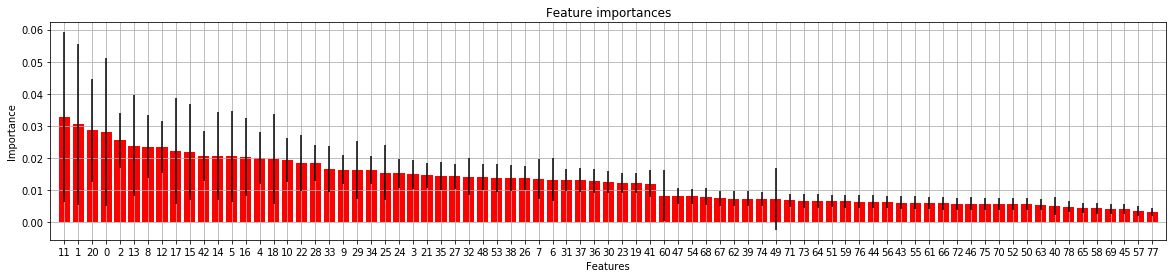

In [16]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,4))
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), 
        importances[indices], 
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()

### Test using MLP

In [21]:
from sklearn.neural_network import MLPClassifier

# Define some hyperparameters we are going to test
param_dist = {"hidden_layer_sizes": [100,128,256,512]}

# Make a handle for our model (initialization or our model without fitted parameters)
mlp = MLPClassifier()

mlp_random_search_res = cross_validate(mlp,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       acc_metric,
                                       5)

print("Best performance: %s" % (mlp_random_search_res.best_score_))
print("With the hyperparameters: %s" % (mlp_random_search_res.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] hidden_layer_sizes=100 ..........................................
[CV] . hidden_layer_sizes=100, score=0.6845008273579702, total=   4.0s
[CV] hidden_layer_sizes=100 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] . hidden_layer_sizes=100, score=0.6545253863134658, total=   5.7s
[CV] hidden_layer_sizes=100 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV] . hidden_layer_sizes=100, score=0.6543346217559359, total=   4.7s
[CV] hidden_layer_sizes=100 ..........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s


[CV] . hidden_layer_sizes=100, score=0.6607734806629835, total=   6.2s
[CV] hidden_layer_sizes=100 ..........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.8s remaining:    0.0s


[CV] . hidden_layer_sizes=100, score=0.6395798783858485, total=   4.6s
[CV] hidden_layer_sizes=128 ..........................................
[CV] . hidden_layer_sizes=128, score=0.6762272476558191, total=   7.1s
[CV] hidden_layer_sizes=128 ..........................................
[CV] . hidden_layer_sizes=128, score=0.6589403973509934, total=   8.5s
[CV] hidden_layer_sizes=128 ..........................................
[CV] . hidden_layer_sizes=128, score=0.6427388183324131, total=   5.2s
[CV] hidden_layer_sizes=128 ..........................................
[CV] . hidden_layer_sizes=128, score=0.6635359116022099, total=   5.9s
[CV] hidden_layer_sizes=128 ..........................................
[CV] . hidden_layer_sizes=128, score=0.6462133775566611, total=   5.4s
[CV] hidden_layer_sizes=256 ..........................................
[CV] . hidden_layer_sizes=256, score=0.6712630998345284, total=  10.4s
[CV] hidden_layer_sizes=256 ..........................................
[CV] .

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] . hidden_layer_sizes=512, score=0.6541436464088398, total=  20.9s
[CV] hidden_layer_sizes=512 ..........................................
[CV] . hidden_layer_sizes=512, score=0.6440022111663902, total=  16.5s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.0min finished


Best performance: 0.6587520706791827
With the hyperparameters: {'hidden_layer_sizes': 100}


In [22]:
mlp = MLPClassifier(hidden_layer_sizes=mlp_random_search_res.best_params_["hidden_layer_sizes"],
                    activation='relu',
                    solver='adam',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=0.001,
                    random_state=0)
mlp.fit(train_x, train_y)
mlp_pred = mlp.predict(test_x)
acc = accuracy_score(test_y, mlp_pred)
precision = precision_score(test_y, mlp_pred, average='macro')
recall = recall_score(test_y, mlp_pred, average='macro')
f1 = f1_score(test_y, mlp_pred, average='macro')
print("Accuracy:  ", acc)
print("Precision: ", precision)
print("Recall:    ", recall)
print("F1 score:  ", f1)
print(classification_report(test_y, mlp_pred, target_names = classes))

Accuracy:   0.6405733186328556
Precision:  0.6640277920608803
Recall:     0.6720964167950452
F1 score:   0.6651901787617006
               precision    recall  f1-score   support

    cytosolic       0.54      0.62      0.58       293
     secreted       0.74      0.75      0.75       159
mitochondrial       0.69      0.76      0.73       130
      nuclear       0.68      0.55      0.61       325

  avg / total       0.65      0.64      0.64       907



### Test using SVM

In [24]:
from sklearn.svm import SVC

# Define some hyperparameters we are going to test
param_dist = {"C": [0.01,0.1,1.0,10], "degree":[1,2,3,4,5]}

# Make a handle for our model (initialization or our model without fitted parameters)
svm = SVC()

svm_random_search_res = cross_validate(svm,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       acc_metric,
                                       5)

print("Best performance: %s" % (svm_random_search_res.best_score_))
print("With the hyperparameters: %s" % (svm_random_search_res.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.01, degree=1 ................................................
[CV] ....... C=0.01, degree=1, score=0.4942084942084942, total=   8.1s
[CV] C=0.01, degree=1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] ....... C=0.01, degree=1, score=0.4806843267108168, total=   8.1s
[CV] C=0.01, degree=1 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.1s remaining:    0.0s


[CV] ....... C=0.01, degree=1, score=0.4803975704030922, total=   8.3s
[CV] C=0.01, degree=1 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.9s remaining:    0.0s


[CV] ........ C=0.01, degree=1, score=0.487292817679558, total=   8.2s
[CV] C=0.01, degree=1 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.7s remaining:    0.0s


[CV] ...... C=0.01, degree=1, score=0.45550027639579876, total=   8.1s
[CV] C=0.01, degree=2 ................................................
[CV] ....... C=0.01, degree=2, score=0.4942084942084942, total=   8.1s
[CV] C=0.01, degree=2 ................................................
[CV] ....... C=0.01, degree=2, score=0.4806843267108168, total=   8.1s
[CV] C=0.01, degree=2 ................................................
[CV] ....... C=0.01, degree=2, score=0.4803975704030922, total=   8.1s
[CV] C=0.01, degree=2 ................................................
[CV] ........ C=0.01, degree=2, score=0.487292817679558, total=   8.1s
[CV] C=0.01, degree=2 ................................................
[CV] ...... C=0.01, degree=2, score=0.45550027639579876, total=   8.2s
[CV] C=0.01, degree=3 ................................................
[CV] ....... C=0.01, degree=3, score=0.4942084942084942, total=   8.2s
[CV] C=0.01, degree=3 ................................................
[CV] .

[CV] ........ C=1.0, degree=3, score=0.6283821093318609, total=   6.2s
[CV] C=1.0, degree=3 .................................................
[CV] ........ C=1.0, degree=3, score=0.6337016574585635, total=   6.0s
[CV] C=1.0, degree=3 .................................................
[CV] ........ C=1.0, degree=3, score=0.6108347153123272, total=   6.0s
[CV] C=1.0, degree=4 .................................................
[CV] ........ C=1.0, degree=4, score=0.6442360728075014, total=   6.0s
[CV] C=1.0, degree=4 .................................................
[CV] ........ C=1.0, degree=4, score=0.6379690949227373, total=   6.3s
[CV] C=1.0, degree=4 .................................................
[CV] ........ C=1.0, degree=4, score=0.6283821093318609, total=   6.0s
[CV] C=1.0, degree=4 .................................................
[CV] ........ C=1.0, degree=4, score=0.6337016574585635, total=   6.1s
[CV] C=1.0, degree=4 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 18.1min finished


Best performance: 0.667366096079514
With the hyperparameters: {'C': 10, 'degree': 1}


In [25]:
svm = SVC(C=svm_random_search_res.best_params_['C'],
          kernel='rbf',
          degree=svm_random_search_res.best_params_['degree'],
          decision_function_shape='ovr',
          probability=False)
svm.fit(train_x, train_y)
svm_pred = svm.predict(test_x)
acc = accuracy_score(test_y, svm_pred)
precision = precision_score(test_y, svm_pred, average='macro')
recall = recall_score(test_y, svm_pred, average='macro')
f1 = f1_score(test_y, svm_pred, average='macro')
print("Accuracy:  ", acc)
print("Precision: ", precision)
print("Recall:    ", recall)
print("F1 score:  ", f1)
print(classification_report(test_y, svm_pred, target_names = classes))

Accuracy:   0.6295479603087101
Precision:  0.6502584100309114
Recall:     0.6548296817699226
F1 score:   0.6522843543732636
               precision    recall  f1-score   support

    cytosolic       0.53      0.55      0.54       293
     secreted       0.75      0.74      0.74       159
mitochondrial       0.68      0.72      0.70       130
      nuclear       0.64      0.61      0.63       325

  avg / total       0.63      0.63      0.63       907



### Test using KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Define some hyperparameters we are going to test
param_dist = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10,15,20,25,30]}

# Make a handle for our model (initialization or our model without fitted parameters)
knn = KNeighborsClassifier()

knn_random_search_res = cross_validate(knn,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       acc_metric,
                                       5)

print("Best performance: %s" % (knn_random_search_res.best_score_))
print("With the hyperparameters: %s" % (knn_random_search_res.best_params_))


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.5543298400441258, total=   1.0s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.5584988962472406, total=   1.0s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.5670900055218111, total=   1.1s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s


[CV] ........... n_neighbors=1, score=0.543646408839779, total=   1.0s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.3s remaining:    0.0s


[CV] ........... n_neighbors=1, score=0.574350469872858, total=   1.1s
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.5267512410369554, total=   1.3s
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.5298013245033113, total=   1.0s
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.5256764218663722, total=   1.1s
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.5226519337016574, total=   1.0s
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.5334438916528469, total=   1.2s
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.5703254274682846, total=   1.1s
[CV] n_neighbors=3 ...................................................
[CV] .

[CV] ......... n_neighbors=25, score=0.5946990612921038, total=   1.5s
[CV] n_neighbors=25 ..................................................
[CV] ......... n_neighbors=25, score=0.5917127071823205, total=   1.4s
[CV] n_neighbors=25 ..................................................
[CV] ......... n_neighbors=25, score=0.5865118850193477, total=   1.3s
[CV] n_neighbors=30 ..................................................
[CV] ......... n_neighbors=30, score=0.6067291781577496, total=   1.4s
[CV] n_neighbors=30 ..................................................
[CV] ......... n_neighbors=30, score=0.5954746136865342, total=   1.4s
[CV] n_neighbors=30 ..................................................
[CV] .......... n_neighbors=30, score=0.597459966869133, total=   1.3s
[CV] n_neighbors=30 ..................................................
[CV] ......... n_neighbors=30, score=0.5867403314917127, total=   1.4s
[CV] n_neighbors=30 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  6.6min finished


In [27]:
knn = KNeighborsClassifier(n_neighbors=knn_random_search_res.best_params_['n_neighbors'])
knn.fit(train_x.to_numpy(), train_y)
knn_pred = knn.predict(test_x.to_numpy())
acc = accuracy_score(test_y, knn_pred)
precision = precision_score(test_y, knn_pred, average='macro')
recall = recall_score(test_y, knn_pred, average='macro')
f1 = f1_score(test_y, knn_pred, average='macro')
print("Accuracy:  ", acc)
print("Precision: ", precision)
print("Recall:    ", recall)
print("F1 score:  ", f1)
print(classification_report(test_y, knn_pred, target_names = classes))

Accuracy:   0.587651598676957
Precision:  0.6235855613212289
Recall:     0.5931552711139292
F1 score:   0.5999472526916692
               precision    recall  f1-score   support

    cytosolic       0.50      0.63      0.56       293
     secreted       0.81      0.57      0.67       159
mitochondrial       0.55      0.63      0.59       130
      nuclear       0.64      0.54      0.59       325

  avg / total       0.61      0.59      0.59       907



### Test using GNB

In [20]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
type(device)

torch.device